All cridets [@hidehisaarai1213](https://www.kaggle.com/hidehisaarai1213)

This notebook based on this [Introduction to Sound Event Detection](https://www.kaggle.com/hidehisaarai1213/introduction-to-sound-event-detection)

### Install packages

In [ ]:
!pip -q install --upgrade pip
!pip -q install timm
!pip -q install torchlibrosa
!pip -q install audiomentations

### import packages

In [ ]:
import os, glob, random, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display
import soundfile as sf

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from functools import partial
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from transformers import get_linear_schedule_with_warmup
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation

import timm
from timm.models.efficientnet import tf_efficientnet_b0_ns

### About Sound Event Detection(SED)

Sound event detection (SED) is the task of detecting the type as well as
the onset and offset times of sound events in audio streams.

In this notebook i will show how to train Sound Event Detection (SED) model with only weak annotation.

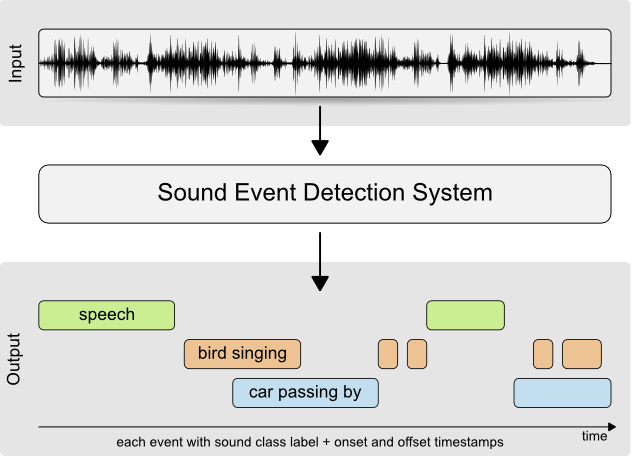

In SED task, we need to detect sound events from continuous (long) audio clip, and provide prediction of what sound event exists from when to when.

for more details

-> [Polyphonic Sound Event Detection
with Weak Labeling Paper](http://www.cs.cmu.edu/~yunwang/papers/cmu-thesis.pdf)

-> [Introduction to Sound Event Detection Notebook](https://www.kaggle.com/hidehisaarai1213/introduction-to-sound-event-detection)


### PANN Utils

-> [PANNs repository](https://github.com/qiuqiangkong/audioset_tagging_cnn/)

-> [PANNs paper](https://arxiv.org/abs/1912.10211)


In [ ]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()

def do_mixup(x: torch.Tensor, mixup_lambda: torch.Tensor):
    """Mixup x of even indexes (0, 2, 4, ...) with x of odd indexes
    (1, 3, 5, ...).
    Args:
      x: (batch_size * 2, ...)
      mixup_lambda: (batch_size * 2,)
    Returns:
      out: (batch_size, ...)
    """
    out = (x[0::2].transpose(0, -1) * mixup_lambda[0::2] +
           x[1::2].transpose(0, -1) * mixup_lambda[1::2]).transpose(0, -1)
    return out


class Mixup(object):
    def __init__(self, mixup_alpha, random_seed=1234):
        """Mixup coefficient generator.
        """
        self.mixup_alpha = mixup_alpha
        self.random_state = np.random.RandomState(random_seed)

    def get_lambda(self, batch_size):
        """Get mixup random coefficients.
        Args:
          batch_size: int
        Returns:
          mixup_lambdas: (batch_size,)
        """
        mixup_lambdas = []
        for n in range(0, batch_size, 2):
            lam = self.random_state.beta(self.mixup_alpha, self.mixup_alpha, 1)[0]
            mixup_lambdas.append(lam)
            mixup_lambdas.append(1. - lam)

        return torch.from_numpy(np.array(mixup_lambdas, dtype=np.float32))

def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()

    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

    def forward(self, input, pool_size=(2, 2), pool_type='avg'):

        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x


class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)
        

### Create Folds

In [ ]:
FOLDS = 5
SEED = 42

train = pd.read_csv("../input/rfcx-species-audio-detection/train_tp.csv").sort_values("recording_id")
ss = pd.read_csv("../input/rfcx-species-audio-detection/sample_submission.csv")

train_gby = train.groupby("recording_id")[["species_id"]].first().reset_index()
train_gby = train_gby.sample(frac=1, random_state=SEED).reset_index(drop=True)
train_gby.loc[:, 'kfold'] = -1

X = train_gby["recording_id"].values
y = train_gby["species_id"].values

kfold = StratifiedKFold(n_splits=FOLDS)
for fold, (t_idx, v_idx) in enumerate(kfold.split(X, y)):
    train_gby.loc[v_idx, "kfold"] = fold

train = train.merge(train_gby[['recording_id', 'kfold']], on="recording_id", how="left")
print(train.kfold.value_counts())
train.to_csv("train_folds.csv", index=False)

### SED Model

1. Model takes raw waveform and converted into log-melspectogram using `torchlibrosa`'s module
2. spectogram converted into 3-channels input for ImageNet pretrain model to extract features from CNN's
3. Although it's downsized through several convolution and pooling layers, the size of it's third dimension and it still contains time information. Each element of this dimension is segment. In SED model, we provide prediction for each of this.

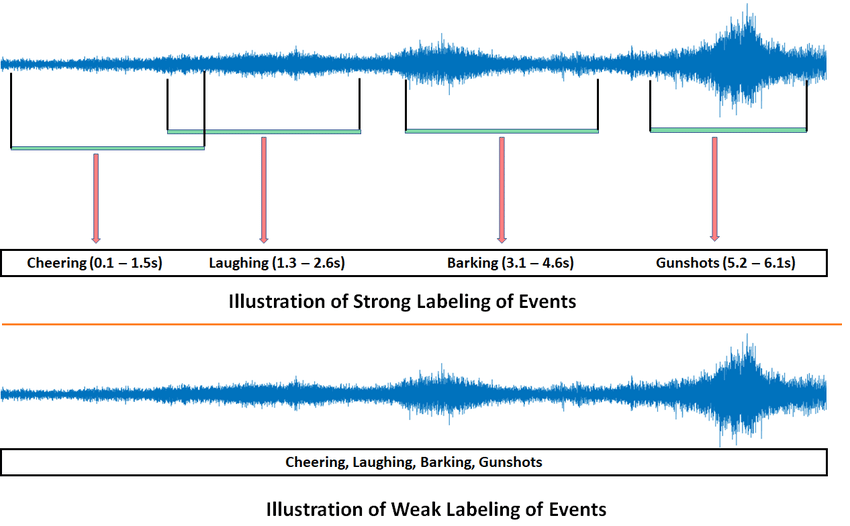

4. This figure gives us an intuitive explanation what is weak annotation and what is strong annotation in terms of sound event detection. For this competition, we only have weak annotation (clip level annotation). Therefore, we need to train our SED model in weakly-supervised manner.

5. In weakly-supervised setting, we only have clip-level annotation, therefore we also need to aggregate that in time axis. Hense, we at first put classifier that outputs class existence probability for each time step just after the feature extractor and then aggregate the output of the classifier result in time axis. In this way we can get both clip-level prediction and segment-level prediction (if the time resolution is high, it can be treated as event-level prediction). Then we train it normally by using BCE loss with clip-level prediction and clip-level annotation.

In [ ]:
encoder_params = {
    "tf_efficientnet_b0_ns": {
        "features": 1280,
        "init_op": partial(tf_efficientnet_b0_ns, pretrained=True, drop_path_rate=0.2)
    }
}


class AudioSEDModel(nn.Module):
    def __init__(self, encoder, sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num):
        super().__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        self.interpolate_ratio = 30  # Downsampled ratio

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
            win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
            n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)
        
        # Model Encoder
        self.encoder = encoder_params[encoder]["init_op"]()
        self.fc1 = nn.Linear(encoder_params[encoder]["features"], 1024, bias=True)
        self.att_block = AttBlock(1024, classes_num, activation="sigmoid")
        self.bn0 = nn.BatchNorm2d(mel_bins)
        self.init_weight()
    
    def init_weight(self):
        init_layer(self.fc1)
        init_bn(self.bn0)
    
    def forward(self, input, mixup_lambda=None):
        """Input : (batch_size, data_length)"""

        x = self.spectrogram_extractor(input)
        # batch_size x 1 x time_steps x freq_bins
        x = self.logmel_extractor(x)
        # batch_size x 1 x time_steps x mel_bins

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        #print(x.shape)

        if self.training:
            x = self.spec_augmenter(x)
        
        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        
        # Output shape (batch size, channels, time, frequency)
        x = x.expand(x.shape[0], 3, x.shape[2], x.shape[3])
        #print(x.shape)
        x = self.encoder.forward_features(x)
        #print(x.shape)
        x = torch.mean(x, dim=3)
        #print(x.shape)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2
        #print(x.shape)

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        #print(x.shape)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        output_dict = {
            'framewise_output' : framewise_output,
            'logit' : logit,
            'clipwise_output' : clipwise_output
        }

        return output_dict

### Dataset

In [ ]:
def crop_or_pad(y, sr, period, record, mode="train"):
    len_y = len(y)
    effective_length = sr * period
    rint = np.random.randint(len(record['t_min']))
    time_start = record['t_min'][rint] * sr
    time_end = record['t_max'][rint] * sr
    if len_y > effective_length:
        # Positioning sound slice
        center = np.round((time_start + time_end) / 2)
        beginning = center - effective_length / 2
        if beginning < 0:
            beginning = 0
        beginning = np.random.randint(beginning, center)
        ending = beginning + effective_length
        if ending > len_y:
            ending = len_y
        beginning = ending - effective_length
        y = y[beginning:ending].astype(np.float32)
    else:
        y = y.astype(np.float32)
        beginning = 0
        ending = effective_length


    beginning_time = beginning / sr
    ending_time = ending / sr
    label = np.zeros(24, dtype='f')

    for i in range(len(record['t_min'])):
        if (record['t_min'][i] <= ending_time) and (record['t_max'][i] >= beginning_time):
            label[record['species_id'][i]] = 1
    
    return y, label

In [ ]:
class SedDataset:
    def __init__(self, df, period=10, stride=5, audio_transform=None, data_path="train", mode="train"):

        self.period = period
        self.stride = stride
        self.audio_transform = audio_transform
        self.data_path = data_path
        self.mode = mode

        self.df = df.groupby("recording_id").agg(lambda x: list(x)).reset_index()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx]

        y, sr = sf.read(f"{self.data_path}/{record['recording_id']}.flac")
        
        if self.mode != "test":
            y, label = crop_or_pad(y, sr, period=self.period, record=record, mode=self.mode)

            if self.audio_transform:
                y = self.audio_transform(samples=y, sample_rate=sr)
        else:
            y_ = []
            i = 0
            effective_length = self.period * sr
            stride = self.stride * sr
            y = np.stack([y[i:i+effective_length].astype(np.float32) for i in range(0, 60*sr+stride-effective_length, stride)])
            label = np.zeros(24, dtype='f')
            if self.mode == "valid":
                for i in record['species_id']:
                    label[i] = 1
        
        return {
            "image" : y,
            "target" : label,
            "id" : record['recording_id']
        }

### Augmentations

In [ ]:
import audiomentations as AA

train_audio_transform = AA.Compose([
    AA.AddGaussianNoise(p=0.5),
    AA.AddGaussianSNR(p=0.5),
    #AA.AddBackgroundNoise("../input/train_audio/", p=1)
    #AA.AddImpulseResponse(p=0.1),
    #AA.AddShortNoises("../input/train_audio/", p=1)
    #AA.FrequencyMask(min_frequency_band=0.0,  max_frequency_band=0.2, p=0.1),
    #AA.TimeMask(min_band_part=0.0, max_band_part=0.2, p=0.1),
    #AA.PitchShift(min_semitones=-0.5, max_semitones=0.5, p=0.1),
    #AA.Shift(p=0.1),
    #AA.Normalize(p=0.1),
    #AA.ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=1, p=0.05),
    #AA.PolarityInversion(p=0.05),
    #AA.Gain(p=0.2)
])

### Utils

In [ ]:
def _lwlrap_sklearn(truth, scores):
    """Reference implementation from https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8"""
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = metrics.label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class MetricMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.y_true = []
        self.y_pred = []
    
    def update(self, y_true, y_pred):
        self.y_true.extend(y_true.cpu().detach().numpy().tolist())
        self.y_pred.extend(y_pred.cpu().detach().numpy().tolist())

    @property
    def avg(self):
        #score_class, weight = lwlrap(np.array(self.y_true), np.array(self.y_pred))
        self.score = _lwlrap_sklearn(np.array(self.y_true), np.array(self.y_pred)) #(score_class * weight).sum()
        return {
            "lwlrap" : self.score
        }

def seed_everithing(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


### Losses

In [ ]:
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss

class PANNsLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.bce = nn.BCELoss()

    def forward(self, input, target):
        input_ = input["clipwise_output"]
        input_ = torch.where(torch.isnan(input_),
                             torch.zeros_like(input_),
                             input_)
        input_ = torch.where(torch.isinf(input_),
                             torch.zeros_like(input_),
                             input_)

        target = target.float()

        return self.bce(input_, target)

### Functions

In [ ]:
def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = AverageMeter()
    scores = MetricMeter()

    model.train()
    t = tqdm(loader)
    for i, sample in enumerate(t):
        optimizer.zero_grad()
        input = sample['image'].to(args.device)
        target = sample['target'].to(args.device)
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if scheduler and args.step_scheduler:
            scheduler.step()

        bs = input.size(0)
        scores.update(target, torch.sigmoid(torch.max(output['framewise_output'], dim=1)[0]))
        losses.update(loss.item(), bs)

        t.set_description(f"Train E:{epoch} - Loss{losses.avg:0.4f}")
    t.close()
    return scores.avg, losses.avg
        
def valid_epoch(args, model, loader, criterion, epoch):
    losses = AverageMeter()
    scores = MetricMeter()
    model.eval()
    with torch.no_grad():
        t = tqdm(loader)
        for i, sample in enumerate(t):
            input = sample['image'].to(args.device)
            target = sample['target'].to(args.device)
            output = model(input)
            loss = criterion(output, target)

            bs = input.size(0)
            scores.update(target, torch.sigmoid(torch.max(output['framewise_output'], dim=1)[0]))
            losses.update(loss.item(), bs)
            t.set_description(f"Valid E:{epoch} - Loss:{losses.avg:0.4f}")
    t.close()
    return scores.avg, losses.avg

def test_epoch(args, model, loader):
    model.eval()
    pred_list = []
    id_list = []
    with torch.no_grad():
        t = tqdm(loader)
        for i, sample in enumerate(t):
            input = sample["image"].to(args.device)
            bs, seq, w = input.shape
            input = input.reshape(bs*seq, w)
            id = sample["id"]
            output = model(input)
            output = torch.sigmoid(torch.max(output['framewise_output'], dim=1)[0])
            output = output.reshape(bs, seq, -1)
            output = torch.sum(output, dim=1)
            #output, _ = torch.max(output, dim=1)
            output = output.cpu().detach().numpy().tolist()
            pred_list.extend(output)
            id_list.extend(id)
    
    return pred_list, id_list

### Main Function

In [ ]:
def main(fold):
    seed_everithing(args.seed)

    args.fold = fold
    args.save_path = os.path.join(args.output_dir, args.exp_name)
    os.makedirs(args.save_path, exist_ok=True)

    train_df = pd.read_csv(args.train_csv)
    sub_df = pd.read_csv(args.sub_csv)
    if args.DEBUG:
        train_df = train_df.sample(200)
    train_fold = train_df[train_df.kfold != fold]
    valid_fold = train_df[train_df.kfold == fold]

    train_dataset = SedDataset(
        df = train_fold,
        period=args.period,
        audio_transform=train_audio_transform,
        data_path=args.train_data_path,
        mode="train"
    )

    valid_dataset = SedDataset(
        df = valid_fold,
        period=args.period,
        stride=5,
        audio_transform=None,
        data_path=args.train_data_path,
        mode="valid"
    )

    test_dataset = SedDataset(
        df = sub_df,
        period=args.period,
        stride=5,
        audio_transform=None,
        data_path=args.test_data_path,
        mode="test"
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.num_workers
    )

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=args.num_workers
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=args.num_workers
    )

    model = AudioSEDModel(**args.model_param)
    model = model.to(args.device)

    if args.pretrain_weights:
        print("---------------------loading pretrain weights")
        model.load_state_dict(torch.load(args.pretrain_weights, map_location=args.device), strict=False)
        model = model.to(args.device)

    criterion = PANNsLoss() #BCEWithLogitsLoss() #MaskedBCEWithLogitsLoss() #BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    num_train_steps = int(len(train_loader) * args.epochs)
    num_warmup_steps = int(0.1 * args.epochs * len(train_loader))
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

    best_lwlrap = -np.inf
    early_stop_count = 0

    for epoch in range(args.start_epcoh, args.epochs):
        train_avg, train_loss = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        valid_avg, valid_loss = valid_epoch(args, model, valid_loader, criterion, epoch)

        if args.epoch_scheduler:
            scheduler.step()
        
        content = f"""
                {time.ctime()} \n
                Fold:{args.fold}, Epoch:{epoch}, lr:{optimizer.param_groups[0]['lr']:.7}\n
                Train Loss:{train_loss:0.4f} - LWLRAP:{train_avg['lwlrap']:0.4f}\n
                Valid Loss:{valid_loss:0.4f} - LWLRAP:{valid_avg['lwlrap']:0.4f}\n
        """
        print(content)
        with open(f'{args.save_path}/log_{args.exp_name}.txt', 'a') as appender:
            appender.write(content+'\n')
        
        if valid_avg['lwlrap'] > best_lwlrap:
            print(f"########## >>>>>>>> Model Improved From {best_lwlrap} ----> {valid_avg['lwlrap']}")
            torch.save(model.state_dict(), os.path.join(args.save_path, f'fold-{args.fold}.bin'))
            best_lwlrap = valid_avg['lwlrap']
            early_stop_count = 0
        else:
            early_stop_count += 1
        #torch.save(model.state_dict(), os.path.join(args.save_path, f'fold-{args.fold}_last.bin'))

        if args.early_stop == early_stop_count:
            print("\n $$$ ---? Ohoo.... we reached early stoping count :", early_stop_count)
            break
    
    model.load_state_dict(torch.load(os.path.join(args.save_path, f'fold-{args.fold}.bin'), map_location=args.device))
    model = model.to(args.device)

    target_cols = sub_df.columns[1:].values.tolist()
    test_pred, ids = test_epoch(args, model, test_loader)
    print(np.array(test_pred).shape)

    test_pred_df = pd.DataFrame({
        "recording_id" : sub_df.recording_id.values
    })
    test_pred_df[target_cols] = test_pred
    test_pred_df.to_csv(os.path.join(args.save_path, f"fold-{args.fold}-submission.csv"), index=False)
    print(os.path.join(args.save_path, f"fold-{args.fold}-submission.csv"))
    

### Config

In [ ]:
class args:
    DEBUG = False

    exp_name = "SED_E0_5F_BASE"
    pretrain_weights = None 
    model_param = {
        'encoder' : 'tf_efficientnet_b0_ns',
        'sample_rate': 48000,
        'window_size' : 512, #* 2, # 512 * 2
        'hop_size' : 512, #345 * 2, # 320
        'mel_bins' : 128, # 60
        'fmin' : 0,
        'fmax' : 48000 // 2,
        'classes_num' : 24
    }
    period = 10
    seed = 42
    start_epcoh = 0 
    epochs = 50
    lr = 1e-3
    batch_size = 16
    num_workers = 4
    early_stop = 15
    step_scheduler = True
    epoch_scheduler = False

    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    train_csv = "train_folds.csv"
    test_csv = "test_df.csv"
    sub_csv = "../input/rfcx-species-audio-detection/sample_submission.csv"
    output_dir = "weights"
    train_data_path = "../input/rfcx-species-audio-detection/train"
    test_data_path = "../input/rfcx-species-audio-detection/test"


### train folds

In [ ]:
main(fold=0)